In [1]:
from pandas import read_csv,DataFrame,read_excel, merge,concat, Series
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 18 days


In [2]:
datacsv          = "peru_ap17/"
data_peru        = "country_data/"
list_csv         = os.listdir(datacsv)

In [3]:
baseline = read_csv(datacsv+"OD_baseline_Peru.csv")
baseline.index = baseline.Name
baseline["O"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))
baseline["D"] = baseline.Name.apply(lambda s: re.search("(.*) - (.*)",s).group(1))

In [4]:
figures = "figures_august/"
if not os.path.exists(figures):
    os.makedirs(figures)

### calculates weights for each node

In [5]:
nodes1 = read_excel(data_peru+"NODE_CID.xlsx","NODES_CID")
nodes2 = read_excel(data_peru+"NODES_10km_TPDA.xlsx","NODES_10km_TPDA")

nodes = merge(nodes1, nodes2, on='CID', how='outer')

#### the function below calculates the weight of a OD pair based on the gravity model

In [6]:
baseline["Ot"] = baseline.O.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Dt"] = baseline.D.replace(nodes.set_index('CID').Sum_TPDA)
baseline["Opop"] = baseline.O.replace(nodes.set_index('CID')["Population Headcount"])
baseline["Dpop"] = baseline.D.replace(nodes.set_index('CID')["Population Headcount"])

#### here we calculate losses for each scenario

In [7]:
baseline.ix[baseline.Total_KM!=0,'weights']=baseline.ix[baseline.Total_KM!=0,'Ot']\
                                            *baseline.ix[baseline.Total_KM!=0,'Dt']\
                                            /baseline.ix[baseline.Total_KM!=0,'Total_KM']**2
baseline.weights.fillna(0,inplace=True)

In [8]:
info_links = read_excel(data_peru+"Traffic_Link_Final_PER_jun03.xlsx","Traffic_Link_Final")
#info_links = read_excel(datacsv+"allinfo.xlsx","Traffic_Link_AllInfo")

In [9]:
if os.path.exists("costs_peru_august2.csv"):
    costs_all = read_csv("costs_peru_august2.csv")
else:
    costs_all = DataFrame(columns=["scenarioID","partial_or_full","part_ruc_increase","ruc_increase","missingroutes",\
                               "num_aff_routes","cost_with_traffic","km_diff"])
    for file in list_csv:
        if ".csv" not in file:
            continue
        if file=="OD_baseline_Peru.csv":
            continue
        if ("cluster" in file):
            continue
        if ("Partial_V2" in file):
            partial_or_full="partial"
            n      = int(re.search('Scenario_OD(.*)_Partial_V2.csv', file).group(1))
            part_ruc_increase = 0.05
        elif ("Partial_v1" in file):
            partial_or_full="partial"
            n      = int(re.search('Scenario_OD(.*)_Partial_v1.csv', file).group(1))
            part_ruc_increase = 0.5
        else:
            partial_or_full='full'
            n      = int(re.search('OD_scenario(.*).csv', file).group(1))
            part_ruc_increase = 0.
        scenar = read_csv(datacsv+file)
        scenar.index = scenar.Name
        
        missingroutes = len(baseline)-len(scenar)
        # we do not take into account the routes that don't have a second best solution
        baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
        # we select only routes that get affected by the disruption
        affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,3)!=1)&(baseline_nm.Total_Ta_r>0)
        subscenar = scenar.ix[affected_routes,:]
        subscenar["weights"] = baseline_nm.weights
        
        traffic = info_links.ix[info_links.ScenarioID==n,"TPDA"].max()
            
        diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                               baseline_nm.ix[affected_routes,"Total_Ta_r"])
        diff_km_from_baseline = (subscenar.Total_KM-baseline_nm.ix[affected_routes,"Total_KM"])
        diff_tot_baseline   = (traffic*diff_ruc_baseline)
        
        ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
        km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
        cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()

        costs_all.loc[len(costs_all),:] = [n,partial_or_full,part_ruc_increase,\
                                           ruc_increase,missingroutes,sum(affected_routes),\
                                           cost_with_traffic,km_diff]

    costs_all.to_csv("costs_peru_august2.csv",index=False)

here I merge the info that CJ sent with the results of the analysis (calculation of disruption costs)

In [10]:
allinfo1 = merge(info_links, costs_all.rename(columns={"scenarioID":"ScenarioID"}), on='ScenarioID', how='inner')
allinfo1.index=allinfo1.ScenarioID

In [11]:
infocoast = read_excel(data_peru+"Traffic_Link_Final_Coastal.xlsx","Traffic_Link_Final")

In [12]:
allinfo = merge(allinfo1, infocoast, on='ScenarioID', how='inner')
allinfo.index=allinfo.ScenarioID

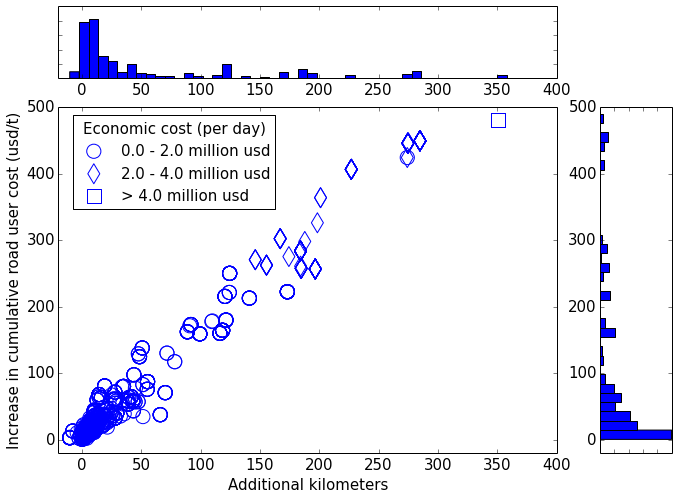

In [13]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(11,8))

x = allinfo.ix[allinfo.partial_or_full=='full','km_diff'].astype(float)
y = allinfo.ix[allinfo.partial_or_full=='full','ruc_increase'].astype(float)
z = allinfo.ix[allinfo.partial_or_full=='full','cost_with_traffic'].astype(float)

groupnum = 3

axScatter = plt.subplot(111)
#axScatter.scatter(x,y,s=10**(-4)*costs['max cost with traffic (usd)'],facecolors='none',edgecolors='blue')
binsz = np.linspace(z.min(), z.max(), groupnum)
grouped = allinfo.ix[allinfo.partial_or_full=='full',:].groupby(np.digitize(z, binsz))

# Create some sizes and some labels.
sizes = [100*(i+1.) for i in range(groupnum+1)]
markers = ['o','d','s']
forleg = np.round(binsz*10**(-6))
labels = ["{} - {} million usd".format(forleg[i],forleg[i+1]) for i in range(groupnum-1)]+\
["> {} million usd".format(forleg[-1])]

for i, (name, group) in enumerate(grouped):
    axScatter.scatter(group.km_diff, group.ruc_increase, \
                      s=200, alpha=1, marker=markers[i], label=labels[i],facecolors='none',edgecolors='blue')
    
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in cumulative road user cost (usd/t)")
#axScatter.set_aspect(1.)

# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", size=1., pad=0.4, sharex=axScatter)
axHisty = divider.append_axes("right", size=1., pad=0.6, sharey=axScatter)

# the scatter plot:
# histograms
binsx = np.arange(x.min(), x.max() + 10, 8)
binsy = np.arange(y.min(), y.max() + 10, 14)
axHistx.hist(x, bins=binsx)
axHistx.yaxis.set_ticklabels([])
axHisty.hist(y, bins=binsy, orientation='horizontal')
axHisty.xaxis.set_ticklabels([])

axScatter.legend(bbox_to_anchor=[-0.05,0.5,0.5,0.5],frameon=True,fontsize=15,title="Economic cost (per day)",\
                 scatterpoints=1)

axScatter.set_ylim([-20,500])
axScatter.set_xlim([-20,400])

#axScatter.annotate("A",xy=(x.loc[111]-20,y.loc[111]-10))
#axScatter.annotate("B",xy=(x.loc[13]+10,y.loc[13]-10))
#axScatter.annotate("C",xy=(x.loc[0]-20,y.loc[0]-10))
#axScatter.annotate("D",xy=(x.loc[168]-20,y.loc[168]-10))

plt.savefig(figures+"per_all_costs_hist_noflood.png",bbox_inches="tight",dpi=100)

A = [111, 113, 114, 115, 116, 493, 494, 495, 496, 497, 533]

B = [ 13,  23,  26,  30,  32,  39,  42,  46,  47,  53,  58,  62, 268,
            269, 270, 271, 272, 274, 275, 276, 277, 285, 286, 289, 290, 291,
            292]
            
C = [0, 1, 2, 3, 4, 5, 6, 20, 22, 54, 243, 260, 261, 275,
            262]
            
D = [168,192]

In [14]:
allinfo.ix[(allinfo.km_diff>270)&(allinfo.km_diff<280),["km_diff","ruc_increase"]]

,km_diff,ruc_increase
ScenarioID,,
0,274.622237,445.833878
1,274.622237,445.833878
2,274.622237,445.833878
3,274.622237,445.833878
4,274.622237,445.833878
5,274.622237,445.833878
6,275.050495,446.141888
20,274.622237,445.833878
22,274.622237,445.833878


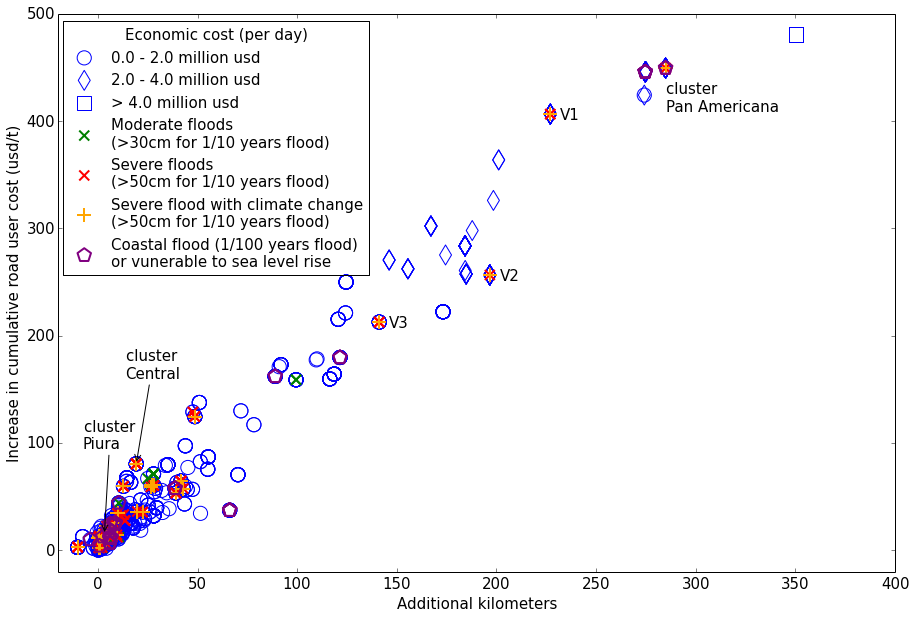

In [15]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(15,10))

x = allinfo.ix[allinfo.partial_or_full=='full','km_diff'].astype(float)
y = allinfo.ix[allinfo.partial_or_full=='full','ruc_increase'].astype(float)
z = allinfo.ix[allinfo.partial_or_full=='full','cost_with_traffic'].astype(float)

groupnum = 3

axScatter = plt.subplot(111)
#axScatter.scatter(x,y,s=10**(-4)*costs['max cost with traffic (usd)'],facecolors='none',edgecolors='blue')
binsz = np.linspace(z.min(), z.max(), groupnum)
grouped = allinfo.ix[allinfo.partial_or_full=='full',:].groupby(np.digitize(z, binsz))

# Create some sizes and some labels.
sizes = [100*(i+1.) for i in range(groupnum+1)]
markers = ['o','d','s']
forleg = np.round(binsz*10**(-6))
labels = ["{} - {} million usd".format(forleg[i],forleg[i+1]) for i in range(groupnum-1)]+\
["> {} million usd".format(forleg[-1])]

for i, (name, group) in enumerate(grouped):
    axScatter.scatter(group.km_diff, group.ruc_increase, \
                      s=200, alpha=1, marker=markers[i], label=labels[i],facecolors='none',edgecolors='blue')
    

select2 = ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])>3)&\
          ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])<5)
axScatter.scatter(x[select2],y[select2],marker="x",s=100,linewidth=2,\
                  c="green",label="Moderate floods\n(>30cm for 1/10 years flood)")

select = ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])>5)
axScatter.scatter(x[select],y[select],marker="x",s=100,linewidth=2,\
                  c="red",label="Severe floods\n(>50cm for 1/10 years flood)")

selectcc = ((allinfo.ix[allinfo.partial_or_full=='full',"GFDL_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>5)|\
((allinfo.ix[allinfo.partial_or_full=='full',"HadGEM2_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>5)|\
((allinfo.ix[allinfo.partial_or_full=='full',"IPSL_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>5)
axScatter.scatter(x[selectcc],y[selectcc],marker="+",s=200,\
                  facecolors='none',edgecolors='orange',linewidth=2,label="Severe flood with climate change\n(>50cm for 1/10 years flood)")

select4 = (allinfo.ix[allinfo.partial_or_full=='full',"Costal"]==1)&\
          (allinfo.ix[allinfo.partial_or_full=='full','Identifier']=="Pan Americana")
#axScatter.scatter(x[select4],y[select4],marker="p",s=200,linewidth=2,\
                  #facecolors='none',edgecolors="magenta",label="Coastal flood (1/100 years flood)")

select3 = (allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"]<2)&\
          (allinfo.ix[allinfo.partial_or_full=='full','Identifier']=="Pan Americana")
axScatter.scatter(x[select3|select4],y[select3|select4],marker="p",s=200,linewidth=2,\
                  facecolors='none',edgecolors="purple",label="Coastal flood (1/100 years flood)\nor vunerable to sea level rise")

    
plt.xlabel("Additional kilometers")
plt.ylabel("Increase in cumulative road user cost (usd/t)")
#axScatter.set_aspect(1.)

axScatter.legend(bbox_to_anchor=[-0.12,0.5,0.5,0.5],frameon=True,fontsize=15,title="Economic cost (per day)",\
                 scatterpoints=1)

axScatter.set_ylim([-20,500])
axScatter.set_xlim([-20,400])

axScatter.annotate("V1",xy=(x.loc[92]+5,y.loc[92]-5))
axScatter.annotate("V2",xy=(x.loc[418]+5,y.loc[418]-5))
axScatter.annotate("V3",xy=(x.loc[157]+5,y.loc[157]-5))
#axScatter.annotate("D",xy=(x.loc[168]-10,y.loc[168]-10))

axScatter.annotate("cluster \nPan Americana",xy=(x[272],y[272]-40))
axScatter.annotate("cluster \nPiura",xy=(x[224],y[224]),xycoords='data',xytext=(x[224]-10,y[224]+80),\
                   arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axScatter.annotate("cluster \nCentral",xy=(x[124],y[124]),xycoords='data',xytext=(x[124]-5,y[124]+80),\
                   arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

plt.savefig(figures+"per_all_costs_nohist_flood.png",bbox_inches="tight",dpi=80)

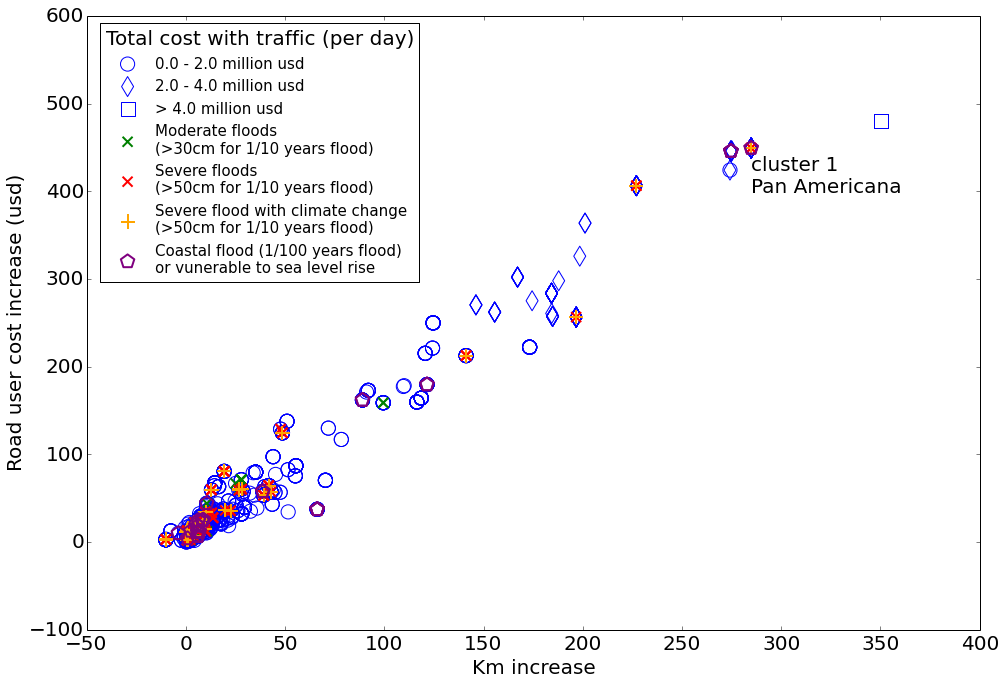

In [19]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.figure(figsize=(16,11))

x = allinfo.ix[allinfo.partial_or_full=='full','km_diff'].astype(float)
y = allinfo.ix[allinfo.partial_or_full=='full','ruc_increase'].astype(float)
z = allinfo.ix[allinfo.partial_or_full=='full','cost_with_traffic'].astype(float)

groupnum = 3

axScatter = plt.subplot(111)
#axScatter.scatter(x,y,s=10**(-4)*costs['max cost with traffic (usd)'],facecolors='none',edgecolors='blue')
binsz = np.linspace(z.min(), z.max(), groupnum)
grouped = allinfo.ix[allinfo.partial_or_full=='full',:].groupby(np.digitize(z, binsz))

# Create some sizes and some labels.
sizes = [100*(i+1.) for i in range(groupnum+1)]
markers = ['o','d','s']
forleg = np.round(binsz*10**(-6))
labels = ["{} - {} million usd".format(forleg[i],forleg[i+1]) for i in range(groupnum-1)]+\
["> {} million usd".format(forleg[-1])]

for i, (name, group) in enumerate(grouped):
    axScatter.scatter(group.km_diff, group.ruc_increase, \
                      s=200, alpha=1, marker=markers[i], label=labels[i],facecolors='none',edgecolors='blue')

select2 = ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])>3)&\
          ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])<5)
axScatter.scatter(x[select2],y[select2],marker="x",s=100,linewidth=2,\
                  c="green",label="Moderate floods\n(>30cm for 1/10 years flood)")

select = ((allinfo.ix[allinfo.partial_or_full=='full',"EU_historical_RP10 (dm)"])>5)
axScatter.scatter(x[select],y[select],marker="x",s=100,linewidth=2,\
                  c="red",label="Severe floods\n(>50cm for 1/10 years flood)")

selectcc = ((allinfo.ix[allinfo.partial_or_full=='full',"GFDL_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>5)|\
((allinfo.ix[allinfo.partial_or_full=='full',"HadGEM2_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>5)|\
((allinfo.ix[allinfo.partial_or_full=='full',"IPSL_8.5_RP10 (dm)"]-\
            0*allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"])>5)
axScatter.scatter(x[selectcc],y[selectcc],marker="+",s=200,\
                  facecolors='none',edgecolors='orange',linewidth=2,label="Severe flood with climate change\n(>50cm for 1/10 years flood)")

select4 = (allinfo.ix[allinfo.partial_or_full=='full',"Costal"]==1)&\
          (allinfo.ix[allinfo.partial_or_full=='full','Identifier']=="Pan Americana")
#axScatter.scatter(x[select4],y[select4],marker="p",s=200,linewidth=2,\
                  #facecolors='none',edgecolors="magenta",label="Coastal flood (1/100 years flood)")

select3 = (allinfo.ix[allinfo.partial_or_full=='full',"Elevation (m)"]<2)&\
          (allinfo.ix[allinfo.partial_or_full=='full','Identifier']=="Pan Americana")
axScatter.scatter(x[select3|select4],y[select3|select4],marker="p",s=200,linewidth=2,\
                  facecolors='none',edgecolors="purple",label="Coastal flood (1/100 years flood)\nor vunerable to sea level rise")


plt.xlabel("Km increase")
plt.ylabel("Road user cost increase (usd)")

axScatter.legend(bbox_to_anchor=[-0.12,0.5,0.5,0.5],frameon=True,fontsize=15,title="Total cost with traffic (per day)",\
                 scatterpoints=1)

#axScatter.annotate("link 418 - Pan Americana",xy=(x[418]+5,y[418]-10))
axScatter.annotate("cluster 1\nPan Americana",xy=(x[272],y[272]-50))

plt.savefig(figures+"all_costs_hist_summary.png",bbox_inches="tight",dpi=400)

In [20]:
sel = (allinfo.partial_or_full=="full")&(allinfo.km_diff>200)&(allinfo.km_diff<250)&(allinfo["EU_historical_RP10 (dm)"]>0)
allinfo.ix[sel,['cost_with_traffic', 'km_diff',"EU_historical_RP10 (dm)","Identifier","Elevation (m)"]]

,cost_with_traffic,km_diff,EU_historical_RP10 (dm),Identifier,Elevation (m)
ScenarioID,,,,,
92,3457816,226.9977,5.0,Pan Americana,19.321243
459,3457816,226.9977,5.5,Pan Americana,23.724309
460,3457816,226.9977,6.0,Pan Americana,20.056773
939,3457816,226.9977,5.0,Pan Americana,31.107856
940,3457816,226.9977,5.0,Pan Americana,28.928910


In [40]:
print(allinfo.ix[sel,['cost_with_traffic', 'km_diff',"EU_historical_RP10 (dm)","Identifier","Elevation (m)"]].index)

Int64Index([92, 459, 460, 939, 940], dtype='int64', name='ScenarioID')


In [41]:
sel = (allinfo.partial_or_full=="full")&(allinfo.km_diff>170)&(allinfo.km_diff<200)&(allinfo["EU_historical_RP10 (dm)"]>0)
allinfo.ix[sel,['cost_with_traffic', 'km_diff',"EU_historical_RP10 (dm)","Identifier","Elevation (m)"]]

,cost_with_traffic,km_diff,EU_historical_RP10 (dm),Identifier,Elevation (m)
ScenarioID,,,,,
411,2189919,184.7616,1,Pan Americana,15.758603
418,2182651,196.6453,65,Pan Americana,14.458181
440,2189919,184.7616,1,Pan Americana,14.850058


In [42]:
print(allinfo.ix[sel,['cost_with_traffic', 'km_diff',"EU_historical_RP10 (dm)","Identifier","Elevation (m)"]].index)

Int64Index([411, 418, 440], dtype='int64', name='ScenarioID')


In [43]:
sel = (allinfo.partial_or_full=="full")&(allinfo.km_diff>100)&(allinfo.km_diff<150)&(allinfo["EU_historical_RP10 (dm)"]>0)
allinfo.ix[sel,['cost_with_traffic', 'km_diff',"EU_historical_RP10 (dm)","Identifier","Elevation (m)"]]

,cost_with_traffic,km_diff,EU_historical_RP10 (dm),Identifier,Elevation (m)
ScenarioID,,,,,
157,1809288,141.1618,17.000000,Pan Americana,170.649039
166,1809288,141.1618,17.000000,Pan Americana,199.315591
174,1809288,141.1618,17.333333,Pan Americana,126.148816
296,1726449,124.5244,3.000000,Pan Americana,60.606407


In [44]:
print(allinfo.ix[sel,['cost_with_traffic', 'km_diff',"EU_historical_RP10 (dm)","Identifier","Elevation (m)"]].index)

Int64Index([157, 166, 174, 296], dtype='int64', name='ScenarioID')


In [27]:
sel = (allinfo.Identifier=='Carretera Central')&(allinfo.partial_or_full=="full")\
&(allinfo["EU_historical_RP10 (dm)"]>0.5)&(allinfo["EU_historical_RP10 (dm)"]<4)

In [29]:
allinfo.ix[sel,['cost_with_traffic', 'km_diff',"EU_historical_RP10 (dm)"]].index

Int64Index([126, 131, 594, 595, 596, 601, 602, 604, 605, 606, 607, 608, 609,
            610, 612, 613, 643],
           dtype='int64', name='ScenarioID')

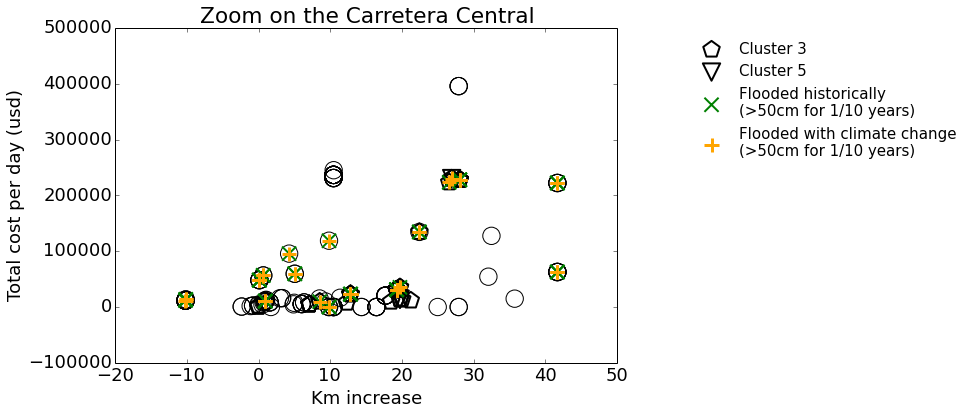

In [29]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.figure(figsize=(9,6))

select1 = (allinfo.Identifier=='Carretera Central')&(allinfo.km_diff<60)&(allinfo.partial_or_full=="full")
select2 = (allinfo.Identifier=='Lake Titicaca')&(allinfo.km_diff<60)&(allinfo.partial_or_full=="full")
cluster1 = np.array([i in [195, 567, 568, 569, 570, 572, 719, 720] for i in allinfo.ScenarioID])
cluster2 = np.array([i in [135,136,138,139,140,545,654] for i in allinfo.ScenarioID])
cluster3 = np.array([i in [124, 126, 131, 622, 623, 624, 642, 643, 645]+list(range(594,621))\
                     for i in allinfo.ScenarioID])
cluster5 = np.array([i in [603,604,605] for i in allinfo.ScenarioID])

axScatter = plt.subplot(111)

axScatter.scatter(allinfo.ix[select1&(~((cluster3)|(cluster5))),"km_diff"],\
                  allinfo.ix[select1&(~((cluster3)|(cluster5))),"cost_with_traffic"],marker="o",s=300,\
                  facecolors='none',edgecolors='black')
#axScatter.scatter(allinfo.ix[select2,"km_diff"],allinfo.ix[select2,"cost_with_traffic"],marker="o",s=400,\
#                  facecolors='none',edgecolors='black',label="Lake Titicaca")

#axScatter.scatter(allinfo.ix[cluster2,"km_diff"],allinfo.ix[cluster2,"cost_with_traffic"]\
 #                ,marker="v",s=300,linewidth=2,facecolors='none',edgecolors='black',label="Cluster 2")

axScatter.scatter(allinfo.ix[cluster3,"km_diff"],allinfo.ix[cluster3,"cost_with_traffic"]\
                  ,marker="p",s=300,linewidth=2,facecolors='none',edgecolors='black',label="Cluster 3")

axScatter.scatter(allinfo.ix[cluster5,"km_diff"],allinfo.ix[cluster5,"cost_with_traffic"]\
                  ,marker="v",s=300,linewidth=2,facecolors='none',edgecolors='black',label="Cluster 5")

plt.xlabel("Km increase")
plt.ylabel("Total cost per day (usd)")
#axScatter.set_aspect(1.)


selecthist = (select1)&((allinfo["EU_historical_RP10 (dm)"])>5)
axScatter.scatter(allinfo.ix[selecthist,"km_diff"],allinfo.ix[selecthist,"cost_with_traffic"],marker="x",s=200,\
                  facecolors='none',edgecolors='green',linewidth=2,label="Flooded historically\n(>50cm for 1/10 years)")

selectcc = select1&((allinfo["GFDL_8.5_RP10 (dm)"]>5)|\
(allinfo.ix[select1,"HadGEM2_8.5_RP10 (dm)"]>5)|\
(allinfo.ix[select1,"IPSL_8.5_RP10 (dm)"]>5))
                        
axScatter.scatter(allinfo.ix[selectcc,"km_diff"],allinfo.ix[selectcc,"cost_with_traffic"],marker="+",s=200,\
                  facecolors='none',edgecolors='orange',linewidth=3,label="Flooded with climate change\n(>50cm for 1/10 years)")

axScatter.legend(bbox_to_anchor=[1.2,0.5,0.5,0.5],frameon=False,fontsize=15,scatterpoints=1)

axScatter.title.set_text("Zoom on the Carretera Central")

plt.savefig("figures/costs_carretera_central.png",bbox_inches="tight",dpi=400)

# Clusters of links

In [547]:
cluster1 = np.array([i in [195, 567, 568, 569, 570, 572, 719, 720] for i in allinfo.ScenarioID])
cluster2 = np.array([i in [135,136,138,139,140,545,654] for i in allinfo.ScenarioID])
cluster3 = np.array([i in [124, 126, 131, 622, 623, 624, 642, 643, 645]+list(range(594,621))\
                     for i in allinfo.ScenarioID])
cluster4 = np.array([i in [271,272] for i in allinfo.ScenarioID])

In [548]:
costs_clusters = DataFrame(columns=["ScenarioID","partial_or_full",'part_ruc_increase',"ruc_increase","missingroutes",\
                           "num_aff_routes","cost_with_traffic","km_diff"])
for file in list_csv:
    if ".csv" not in file:
        continue
    if "cluster" not in file:
        continue
    if ("partial" in file):
        partial_or_full="partial"
        n      = int(re.search('OD_scenario_cluster(.*)_partial.csv', file).group(1))
        part_ruc_increase = 0.05
    else:
        partial_or_full="full"
        n      = int(re.search('OD_scenario_cluster(.*).csv', file).group(1))
        part_ruc_increase = 0.
    scenar = read_csv(datacsv+file)
    scenar.index = scenar.Name
    

    missingroutes = len(baseline)-len(scenar)
    # we do not take into account the routes that don't have a second best solution
    baseline_nm = baseline.ix[[i in scenar.index for i in baseline.index],:]
    # we select only routes that get affected by the disruption
    affected_routes = (np.round(scenar.Total_Ta_r/baseline_nm.Total_Ta_r,3)!=1)&(baseline_nm.Total_Ta_r!=0)
    subscenar = scenar.ix[affected_routes,:]
    subscenar["weights"] = baseline_nm.ix[affected_routes,'weights']

    traffic = info_links.ix[info_links.ScenarioID,"TPDA"].values[0]

    diff_ruc_baseline   = (subscenar.Total_Ta_r-\
                           baseline_nm.ix[affected_routes,"Total_Ta_r"]).dropna()
    diff_km_from_baseline = (subscenar.Total_KM-\
                             baseline_nm.ix[affected_routes,"Total_KM"]).dropna()
    diff_tot_baseline   = (traffic*diff_ruc_baseline).dropna()
    
    if sum(affected_routes)>0:
        ruc_increase      = np.sum(diff_ruc_baseline*subscenar.weights)/subscenar.weights.sum()
        km_diff = np.sum(diff_km_from_baseline*subscenar.weights)/subscenar.weights.sum()
        cost_with_traffic  = np.sum(diff_tot_baseline*subscenar.weights)/subscenar.weights.sum()
    else:
        ruc_increase      = 0
        km_diff = 0
        cost_with_traffic  = 0

    costs_clusters.loc[len(costs_clusters),:] = ["cluster{}".format(n),partial_or_full,part_ruc_increase,\
                                                 ruc_increase,missingroutes,sum(affected_routes),\
                                       cost_with_traffic,km_diff]

In [549]:
costs_all.ix[costs_all.partial_or_full=='partial',:]

,scenarioID,partial_or_full,part_ruc_increase,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
960,124,partial,0.5,5.769209,0,589,39842.16,0.003431699
961,124,partial,0.05,0.5773652,0,217,3987.284,-0.02803061
962,418,partial,0.5,1.374826,0,1931,9494.548,0.0001352898
963,418,partial,0.05,NaN,0,91,NaN,NaN
964,421,partial,0.5,0.1428674,0,95,986.642,8.137787e-08
965,421,partial,0.05,-0.2040902,0,101,-1409.447,-0.1839719
966,720,partial,0.5,2.833426,0,639,19567.64,-0.1352705
967,720,partial,0.05,0.2819796,0,217,1947.351,2.069837e-07


In [550]:
costs_clusters

,ScenarioID,partial_or_full,part_ruc_increase,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
0,cluster2,full,0,34.45108,0,412,237919.1,9.826937
1,cluster2,partial,0.05,0.5391595,0,64,3723.436,2.914198e-07
2,cluster3,full,0,122.9614,0,538,849171.4,75.89715
3,cluster3,partial,0.05,2.886004,0,538,19930.74,0.003388464
4,cluster4,full,0,449.4244,0,1874,3103725,284.8397
5,cluster4,partial,0.05,0.592524,0,70,4091.971,-8.977825e-07


In [551]:
allinfo = allinfo.append(costs_clusters,ignore_index=True)

In [552]:
for clu in ['cluster2', 'cluster3', 'cluster4']:

    for col in ['ADMIN_NAME', 'CITY_NAME', 'CLASS', 'CNTRY_NAME', 'CODIGO', 'COND1', 'CORR_ID','Identifier',\
               'LANES', 'NAME_0', 'OD', 'OPTIMAL', 'STATUS', 'STATUS.1', 'SURFACE1','TERRAIN', 'TID',]:
        allinfo.ix[allinfo.ScenarioID==clu,col]=allinfo.ix[eval(clu),col].iloc[0]

    for climat in ['EU_historical','GFDL_8.5','HadGEM2_8.5','IPSL_8.5']:
        for RP in [5,10,25,50,100,250,500,1000]:
            col = "{}_RP{} (cm)".format(climat,RP)
            allinfo.ix[allinfo.ScenarioID==clu,col]=allinfo.ix[eval(clu),col].max()

    for col in ["KM"]:
        allinfo.ix[allinfo.ScenarioID==clu,col]=allinfo.ix[eval(clu),col].sum()

    for col in ['Elev_Max (m)','TPDA']:
        allinfo.ix[allinfo.ScenarioID==clu,col]=allinfo.ix[eval(clu),col].max()

    for col in ['Elev_Min (m)']:
        allinfo.ix[allinfo.ScenarioID==clu,col]=allinfo.ix[eval(clu),col].min()

In [460]:
allinfo.columns

Index(['ADMIN_NAME', 'CITY_NAME', 'CLASS', 'CNTRY_NAME', 'CODIGO', 'COND1', 'CORR_ID', 'EU_historical_RP10 (cm)', 'EU_historical_RP100 (cm)', 'EU_historical_RP1000 (cm)', 'EU_historical_RP25 (cm)', 'EU_historical_RP250 (cm)', 'EU_historical_RP5 (cm)', 'EU_historical_RP50 (cm)', 'EU_historical_RP500 (cm)', 'Elev_Max (m)', 'Elev_Mean (m)', 'Elev_Min (m)', 'GFDL_8.5_RP10 (cm)', 'GFDL_8.5_RP100 (cm)', 'GFDL_8.5_RP1000 (cm)', 'GFDL_8.5_RP25 (cm)', 'GFDL_8.5_RP250 (cm)', 'GFDL_8.5_RP5 (cm)', 'GFDL_8.5_RP50 (cm)', 'GFDL_8.5_RP500 (cm)', 'HadGEM2_8.5_RP10 (cm)', 'HadGEM2_8.5_RP100 (cm)', 'HadGEM2_8.5_RP1000 (cm)', 'HadGEM2_8.5_RP25 (cm)', 'HadGEM2_8.5_RP250 (cm)', 'HadGEM2_8.5_RP5 (cm)', 'HadGEM2_8.5_RP50 (cm)', 'HadGEM2_8.5_RP500 (cm)', 'INTERVEN', 'IPSL_8.5_RP10 (cm)', 'IPSL_8.5_RP100 (cm)', 'IPSL_8.5_RP1000 (cm)', 'IPSL_8.5_RP25 (cm)', 'IPSL_8.5_RP250 (cm)', 'IPSL_8.5_RP5 (cm)', 'IPSL_8.5_RP50 (cm)', 'IPSL_8.5_RP500 (cm)', 'Identifier', 'KM', 'LANES', 'NAME_0', 'OD', 'OPTIMAL', 'STATUS', 'S

In [553]:
cluster1 = np.array([i in [195, 567, 568, 569, 570, 572, 719, 720] for i in allinfo.ScenarioID])
cluster2 = np.array([i in [135,136,138,139,140,545,654] for i in allinfo.ScenarioID])
cluster3 = np.array([i in [124, 126, 131, 622, 623, 624, 642, 643, 645]+list(range(594,621))\
                     for i in allinfo.ScenarioID])
cluster4 = np.array([i in [271,272] for i in allinfo.ScenarioID])

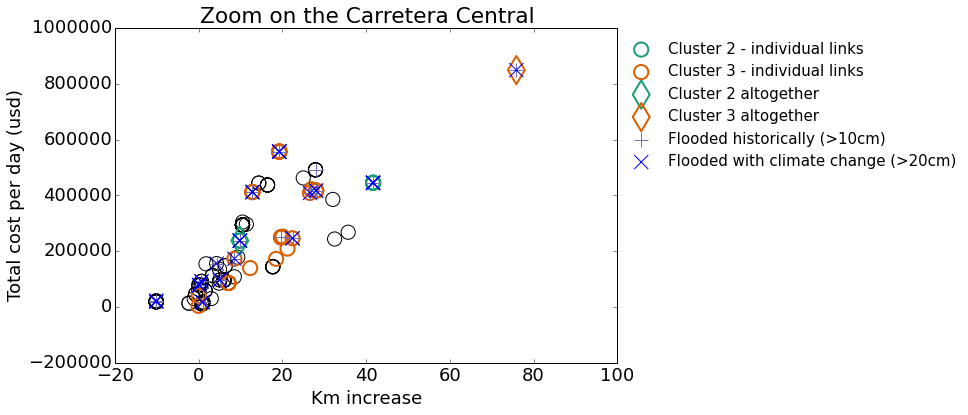

In [554]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.figure(figsize=(9,6))

select1 = (allinfo.Identifier=='Carretera Central')&(allinfo.km_diff<60)&(allinfo.partial_or_full=="full")
select2 = (allinfo.Identifier=='Lake Titicaca')&(allinfo.km_diff<60)&(allinfo.partial_or_full=="full")

cluster2all = (allinfo.ScenarioID=="cluster2")&(allinfo.partial_or_full=="full")
cluster3all = (allinfo.ScenarioID=="cluster3")&(allinfo.partial_or_full=="full")

axScatter = plt.subplot(111)

axScatter.scatter(allinfo.ix[select1&(~((cluster2)|(cluster3))),"km_diff"],\
                  allinfo.ix[select1&(~((cluster2)|(cluster3))),"cost_with_traffic"],marker="o",s=200,\
                  facecolors='none',edgecolors='black')
#axScatter.scatter(allinfo.ix[select2,"km_diff"],allinfo.ix[select2,"cost_with_traffic"],marker="o",s=400,\
#                  facecolors='none',edgecolors='black',label="Lake Titicaca")

axScatter.scatter(allinfo.ix[cluster2,"km_diff"],allinfo.ix[cluster2,"cost_with_traffic"]\
                 ,marker="o",s=200,linewidth=2,facecolors='none',edgecolors='#1b9e77',label="Cluster 2 - individual links")

axScatter.scatter(allinfo.ix[cluster3,"km_diff"],allinfo.ix[cluster3,"cost_with_traffic"]\
                  ,marker="o",s=200,linewidth=2,facecolors='none',edgecolors='#d95f02',label="Cluster 3 - individual links")

axScatter.scatter(allinfo.ix[cluster2all,"km_diff"],\
                  allinfo.ix[cluster2all,"cost_with_traffic"],marker="d",s=400,\
                  facecolors='none',linewidth=2,edgecolors='#1b9e77',label="Cluster 2 altogether")

axScatter.scatter(allinfo.ix[cluster3all,"km_diff"],\
                  allinfo.ix[cluster3all,"cost_with_traffic"],marker="d",s=400,\
                  facecolors='none',linewidth=2,edgecolors='#d95f02',label="Cluster 3 altogether")

plt.xlabel("Km increase")
plt.ylabel("Total cost per day (usd)")
#axScatter.set_aspect(1.)


selecthist = (cluster3all|select1)&(allinfo["EU_historical_RP100 (cm)"]>10)
axScatter.scatter(allinfo.ix[selecthist,"km_diff"],allinfo.ix[selecthist,"cost_with_traffic"],marker="+",s=200,\
                  facecolors='none',edgecolors='#7570b3',linewidth=1,label="Flooded historically (>10cm)")

selectcc = (cluster3all|select1)&((allinfo["GFDL_8.5_RP100 (cm)"]>20)|\
(allinfo.ix[select1,"HadGEM2_8.5_RP100 (cm)"]>20)|\
(allinfo.ix[select1,"IPSL_8.5_RP100 (cm)"]>20))
axScatter.scatter(allinfo.ix[selectcc,"km_diff"],allinfo.ix[selectcc,"cost_with_traffic"],marker="x",s=200,\
                  facecolors='none',edgecolors='blue',linewidth=1,label="Flooded with climate change (>20cm)")

axScatter.legend(bbox_to_anchor=[1.2,0.5,0.5,0.5],frameon=False,fontsize=15,scatterpoints=1)

axScatter.title.set_text("Zoom on the Carretera Central")

#plt.savefig("figures/costs_carretera_central.png",bbox_inches="tight",dpi=400)

In [437]:
allinfo.ix[[271,272],["km_diff","cost_with_traffic","GFDL_8.5_RP100 (cm)"]]

,km_diff,cost_with_traffic,GFDL_8.5_RP100 (cm)
ScenarioID,,,
271,284.8397,3103725,14
272,284.8397,3103725,14


In [484]:
costs_clusters

,ScenarioID,partial_or_full,part_ruc_increase,ruc_increase,missingroutes,num_aff_routes,cost_with_traffic,km_diff
0,cluster2,full,0,34.45108,0,412,237919.1,9.826937
1,cluster2,partial,0.05,1.141321,0,344,7881.961,-0.005090185
2,cluster3,full,0,122.9614,0,538,849171.4,75.89715
3,cluster3,partial,0.05,2.886004,0,538,19930.74,0.003388464
4,cluster4,full,0,449.4244,0,1874,3103725,284.8397
5,cluster4,partial,0.05,0.592524,0,70,4091.971,-8.977825e-07


# Second part: calculation of expected annual losses

In [488]:
allinfo.ix[[i in [418,"cluster4","cluster3"] for i in allinfo.ScenarioID],\
           ["ruc_increase","missingroutes","num_aff_routes","cost_with_traffic","km_diff"]].to_csv("table1.csv")

The function below creates the step function between water level and % of traffic redirected to the second best road

In [406]:
def steps(cm,redirection):
    if redirection==0:
        if cm<5:
            percent = 0
        elif (cm>=5)&(cm<15):
            percent = 0.3
        elif (cm>=15)&(cm<25):
            percent = 0.5
        elif (cm>=25)&(cm<40):
            percent = 0.8
        else:
            percent = 1
    elif redirection==1:
        if cm<3:
            percent = 0
        elif (cm>=3)&(cm<10):
            percent = 0.4
        elif (cm>=10)&(cm<20):
            percent = 0.6
        elif (cm>=20)&(cm<30):
            percent = 0.9
        else:
            percent = 1
    elif redirection==2:
        if cm<2:
            percent = 0
        elif (cm>=2)&(cm<10):
            percent = 0.5
        elif (cm>=10)&(cm<15):
            percent = 0.7
        elif (cm>=15)&(cm<25):
            percent = 0.9
        else:
            percent = 1
    return percent

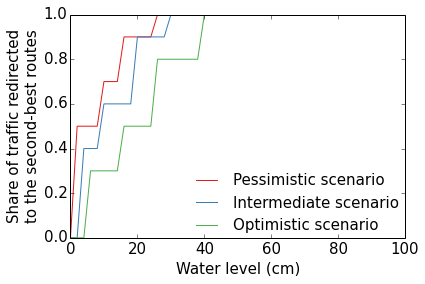

In [277]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,4))

xx = range(0,100,2)
plt.plot(xx,[steps(i,2) for i in xx],label="Pessimistic scenario",color="#e41a1c")
plt.plot(xx,[steps(i,1) for i in xx],label="Intermediate scenario",color="#377eb8")
plt.plot(xx,[steps(i,0) for i in xx],label="Optimistic scenario",color="#4daf4a")



plt.xlabel("Water level (cm)")
plt.ylabel("Share of traffic redirected\nto the second-best routes")
plt.legend(bbox_to_anchor=[0.52,-0.15,0.5,0.5],frameon=False,fontsize=15)
plt.savefig(figures+"traffic_scenarios.png",bbox_inches="tight",dpi=400)

The function below creates the function between water level and duration of the disruption

In [407]:
from scipy.interpolate import InterpolatedUnivariateSpline
def days(length):
    s = InterpolatedUnivariateSpline([0, 5, 30, 50, 200], [0,3*length,15*length,40*length,365*length], k=1)
    return s

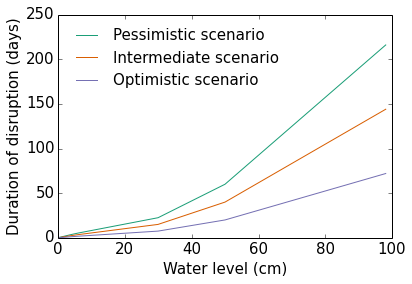

In [279]:
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(6,4))

xx = range(0,100,2)
s=days(1.5)
plt.plot(xx,[s(i,0) for i in xx],label="Pessimistic scenario",color='#1b9e77')
s=days(1)
plt.plot(xx,[s(i,0) for i in xx],label="Intermediate scenario",color='#d95f02')
s2=days(0.5)
plt.plot(xx,[s2(i,0) for i in xx],label="Optimistic scenario",color='#7570b3')

plt.xlabel("Water level (cm)")
plt.ylabel("Duration of disruption (days)")
plt.legend(bbox_to_anchor=[0.2,0.5,0.5,0.5],frameon=False,fontsize=15)
plt.savefig(figures+"duration_scenarios.png",bbox_inches="tight",dpi=400)